# Feature Engineering - Binary Classification (Non-Diabetic vs Diabetic)

This notebook performs feature engineering for **binary classification**, combining prediabetes and diabetes into a single "Diabetic" class.

**Target Variable:**
- 0 = Non-Diabetic (healthy)
- 1 = Diabetic (prediabetes + diabetes combined)

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load Cleaned Data

In [3]:
# Load the cleaned dataset
df = pd.read_csv('../data/processed/CDC_Diabetes_Dataset_clean.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nOriginal Target Distribution:")
print(df['Diabetes_012'].value_counts().sort_index())

Dataset Shape: (229781, 28)

Original Target Distribution:
Diabetes_012
0.0    190055
1.0      4629
2.0     35097
Name: count, dtype: int64


## 2. Create Binary Target Variable

Combine prediabetes (1) and diabetes (2) into a single "Diabetic" class (1).

Binary Target Distribution:
Diabetes_binary
0    190055
1     39726
Name: count, dtype: int64

Class Proportions:
Diabetes_binary
0    82.71
1    17.29
Name: proportion, dtype: float64


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/figures/binary_target_distribution.png'

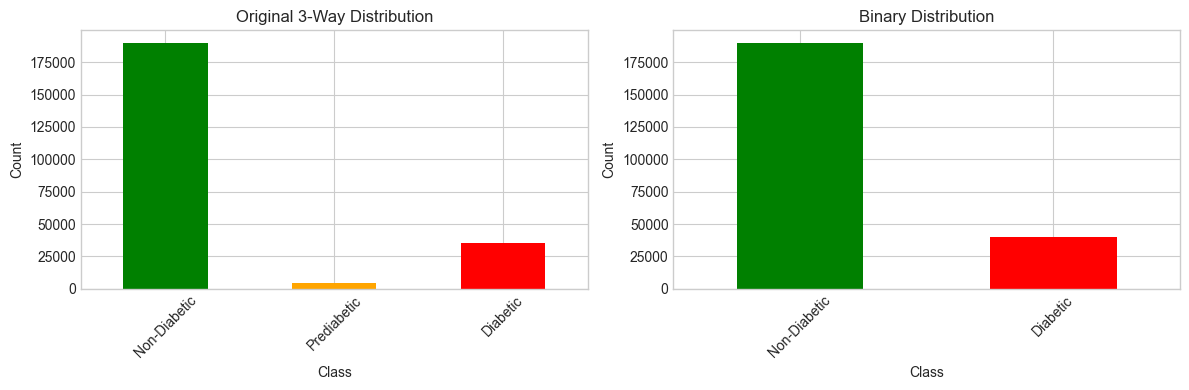

In [4]:
# Create binary target: 0 = Non-Diabetic, 1 = Diabetic (prediabetes + diabetes)
df['Diabetes_binary'] = (df['Diabetes_012'] > 0).astype(int)

print("Binary Target Distribution:")
print(df['Diabetes_binary'].value_counts())
print(f"\nClass Proportions:")
print(df['Diabetes_binary'].value_counts(normalize=True).round(4) * 100)

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original 3-way distribution
df['Diabetes_012'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
axes[0].set_title('Original 3-Way Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Diabetic', 'Prediabetic', 'Diabetic'], rotation=45)

# Binary distribution
df['Diabetes_binary'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('Binary Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-Diabetic', 'Diabetic'], rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/binary_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Feature Engineering

Create new features to improve model performance.

In [ ]:
# Create a copy for feature engineering
df_fe = df.copy()

# 1. BMI Categories (WHO Classification)
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif bmi < 25:
        return 1  # Normal
    elif bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

df_fe['BMI_Category'] = df_fe['BMI'].apply(categorize_bmi)

# 2. Age Groups (decades)
df_fe['Age_Group'] = pd.cut(df_fe['Age'], bins=[0, 3, 6, 9, 13], labels=[0, 1, 2, 3]).astype(int)

# 3. Health Risk Score (composite)
df_fe['Health_Risk_Score'] = (
    df_fe['HighBP'] + 
    df_fe['HighChol'] + 
    df_fe['Smoker'] + 
    df_fe['Stroke'] + 
    df_fe['HeartDiseaseorAttack']
)

# 4. Lifestyle Score (positive behaviors)
df_fe['Lifestyle_Score'] = (
    df_fe['Fruits'] + 
    df_fe['Veggies'] + 
    df_fe['PhysActivity'] - 
    df_fe['HvyAlcoholConsump']
)

# 5. Healthcare Access Score
df_fe['Healthcare_Access'] = (
    df_fe['AnyHealthcare'] + 
    df_fe['NoDocbcCost'].apply(lambda x: 1 - x)  # Inverse - no cost barrier is good
)

# 6. BMI * Age Interaction
df_fe['BMI_Age_Interaction'] = df_fe['BMI'] * df_fe['Age']

# 7. Physical Health Burden (days with issues)
df_fe['Health_Burden'] = df_fe['PhysHlth'] + df_fe['MentHlth']

# 8. Mobility Issues
df_fe['Mobility_Issues'] = df_fe['DiffWalk']

print("New Features Created:")
print(df_fe[['BMI_Category', 'Age_Group', 'Health_Risk_Score', 'Lifestyle_Score', 
             'Healthcare_Access', 'BMI_Age_Interaction', 'Health_Burden']].describe())

## 4. Prepare Features and Target

In [ ]:
# Define feature columns (exclude original target and binary target)
exclude_cols = ['Diabetes_012', 'Diabetes_binary']
feature_cols = [col for col in df_fe.columns if col not in exclude_cols]

X = df_fe[feature_cols]
y = df_fe['Diabetes_binary']

print(f"Features Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
print(f"\nFeature Columns ({len(feature_cols)}):")
print(feature_cols)

## 5. Train-Test Split

In [ ]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")
print(f"\nTraining Target Distribution:")
print(y_train.value_counts())
print(f"\nTest Target Distribution:")
print(y_test.value_counts())

## 6. Handle Class Imbalance with SMOTE

In [ ]:
# Apply SMOTE to balance classes
print("Before SMOTE:")
print(f"Class distribution: {Counter(y_train)}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Class distribution: {Counter(y_train_balanced)}")
print(f"Training samples increased from {len(y_train)} to {len(y_train_balanced)}")

# Visualize before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pd.Series(y_train).value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Diabetic', 'Diabetic'], rotation=0)

pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-Diabetic', 'Diabetic'], rotation=0)

plt.tight_layout()
plt.savefig('../outputs/figures/binary_smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Feature Scaling

In [ ]:
# Standard Scaling
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_balanced),
    columns=feature_cols
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_cols
)

print("Scaled Training Data Statistics:")
print(X_train_scaled.describe().round(3))

## 8. Feature Correlation Analysis

In [ ]:
# Correlation with target
correlation_with_target = X_train.corrwith(y_train).sort_values(ascending=False)

print("Feature Correlation with Binary Target:")
print(correlation_with_target.round(4))

# Visualize top correlations
plt.figure(figsize=(10, 8))
correlation_with_target.plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Diabetes (Binary)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../outputs/figures/binary_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Save Processed Data

In [ ]:
# Save the processed datasets
import os
os.makedirs('../data/processed', exist_ok=True)

# Save unscaled data
X_train.to_csv('../data/processed/binary_X_train.csv', index=False)
X_test.to_csv('../data/processed/binary_X_test.csv', index=False)
y_train.to_csv('../data/processed/binary_y_train.csv', index=False)
y_test.to_csv('../data/processed/binary_y_test.csv', index=False)

# Save balanced data
X_train_balanced.to_csv('../data/processed/binary_X_train_balanced.csv', index=False)
pd.Series(y_train_balanced).to_csv('../data/processed/binary_y_train_balanced.csv', index=False)

# Save scaled data
X_train_scaled.to_csv('../data/processed/binary_X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/binary_X_test_scaled.csv', index=False)

# Save scaler for later use
import joblib
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/binary_scaler.pkl')

print("✓ All binary classification data saved successfully!")
print(f"\nFiles saved:")
print("  - binary_X_train.csv, binary_X_test.csv")
print("  - binary_y_train.csv, binary_y_test.csv")
print("  - binary_X_train_balanced.csv, binary_y_train_balanced.csv")
print("  - binary_X_train_scaled.csv, binary_X_test_scaled.csv")
print("  - binary_scaler.pkl")

## 10. Summary

### Binary Classification Setup Complete

| Aspect | Details |
|--------|---------|
| **Target** | 0 = Non-Diabetic, 1 = Diabetic (prediabetes + diabetes) |
| **Original Features** | 21 |
| **Engineered Features** | 8 |
| **Total Features** | 29 |
| **Training Samples (Original)** | See output above |
| **Training Samples (Balanced)** | See output above |
| **Test Samples** | See output above |
| **Scaling** | StandardScaler |
| **Balancing** | SMOTE |

### Next Steps
1. Train binary classification models
2. Evaluate using accuracy, precision, recall, F1-score, AUC-ROC
3. Compare with 3-way classification results

## 10. Summary

### Binary Classification Setup Complete

| Aspect | Details |
|--------|---------|
| **Target** | 0 = Non-Diabetic, 1 = Diabetic (prediabetes + diabetes) |
| **Original Features** | 21 |
| **Engineered Features** | 8 |
| **Total Features** | 29 |
| **Training Samples (Original)** | See output above |
| **Training Samples (Balanced)** | See output above |
| **Test Samples** | See output above |
| **Scaling** | StandardScaler |
| **Balancing** | SMOTE |

### Next Steps
1. Train binary classification models
2. Evaluate using accuracy, precision, recall, F1-score, AUC-ROC
3. Compare with 3-way classification results